# Mean Variance Optimization

## Calculattion of the Efficient Frontier of a Portfolio

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotx
import plotly.graph_objects as go
plt.style.use(matplotx.styles.pitaya_smoothie['dark'])

# 1. Load the stock data.
df = pd.read_csv(r"D:\OneDrive\Documents\Python_\GitHub\Project-Alpha\Mean Variance Optimization\stock_data_quarterly.csv")
print(df.info())

#df['Date'] = pd.to_datetime(df['Date'])
#df = df.sort_values(by='Date', ascending=False)
#print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               42 non-null     int64  
 1   General Electric   42 non-null     float64
 2   Chesapeake Energy  42 non-null     float64
 3   AT&T               42 non-null     float64
 4   Cisco Systems      42 non-null     float64
 5   Campbell Soup      42 non-null     float64
 6   S&P 500            42 non-null     float64
dtypes: float64(6), int64(1)
memory usage: 2.4 KB
None


 ### Quarterly Returns Calculation

In [12]:
company_list = list(df.columns)
company_list.pop(0)

def q_return(company_name, n):
    for i in range(n):
        df.loc[i+1, company_name + " Returns %"] = ((df.loc[i+1, company_name] / df.loc[i, company_name] - 1)*100).round(2)
    return df

for i in company_list:
    df = q_return(i, 41)
print(df.head())
print(df)
# selected = list(df.columns[1:])
# returns_quarterly = df[selected].pct_change()
# print(returns_quarterly)

    Date  General Electric  Chesapeake Energy   AT&T  Cisco Systems  \
0  39447             37.08              39.36  42.12          27.25   
1  39538             36.63              45.76  37.71          24.08   
2  39629             26.35              66.77  32.75          23.47   
3  39721             23.87              33.29  28.35          22.25   
4  39813             15.82              15.34  28.19          16.18   

   Campbell Soup  S&P 500  General Electric Returns %  \
0          35.77  1468.36                         NaN   
1          33.91  1322.70                       -1.21   
2          33.03  1280.00                      -28.06   
3          38.30  1166.36                       -9.41   
4          29.49   903.25                      -33.72   

   Chesapeake Energy Returns %  AT&T Returns %  Cisco Systems Returns %  \
0                          NaN             NaN                      NaN   
1                        16.26          -10.47                   -11.63   
2    

### Mean Calcualtion

In [13]:
company_return_list = list(df.columns[-6:])

stocks_mean = df.iloc[:, -6:].mean().round(2)
stocks_mean = stocks_mean.to_frame().T
stocks_mean.columns = company_list
stocks_mean.index = ['Mean']
print(stocks_mean)

      General Electric  Chesapeake Energy  AT&T  Cisco Systems  Campbell Soup  \
Mean              -1.2              -3.06 -0.15           1.85           0.85   

      S&P 500  
Mean     1.77  


### Sample Standard Deviation Calculation

In [14]:
stocks_std = df.iloc[:, -6:].std().round(2)
stocks_std = stocks_std.to_frame().T
stocks_std.columns = company_list
stocks_std.index = ['Standard Deviation']
print(stocks_std)

                    General Electric  Chesapeake Energy  AT&T  Cisco Systems  \
Standard Deviation             16.13               23.8  8.04          11.35   

                    Campbell Soup  S&P 500  
Standard Deviation           9.46     8.06  


### Calucaltion of covariance metrix

<Axes: >

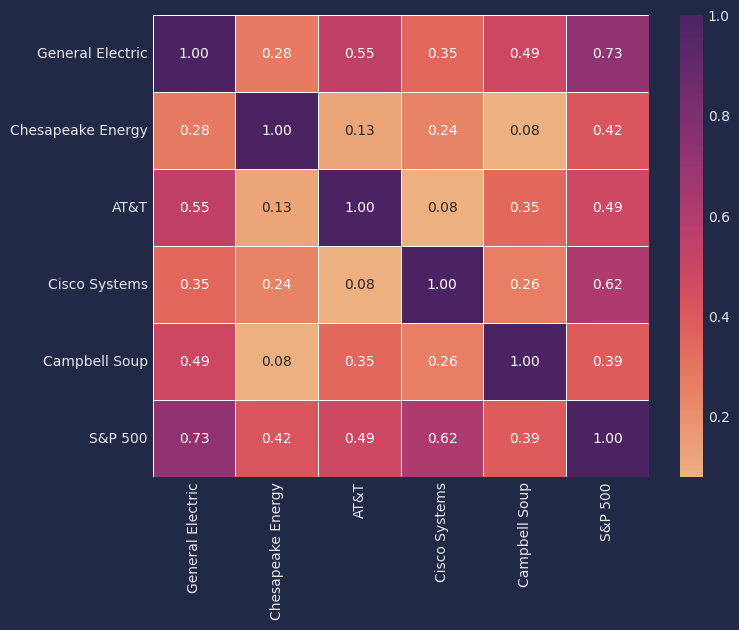

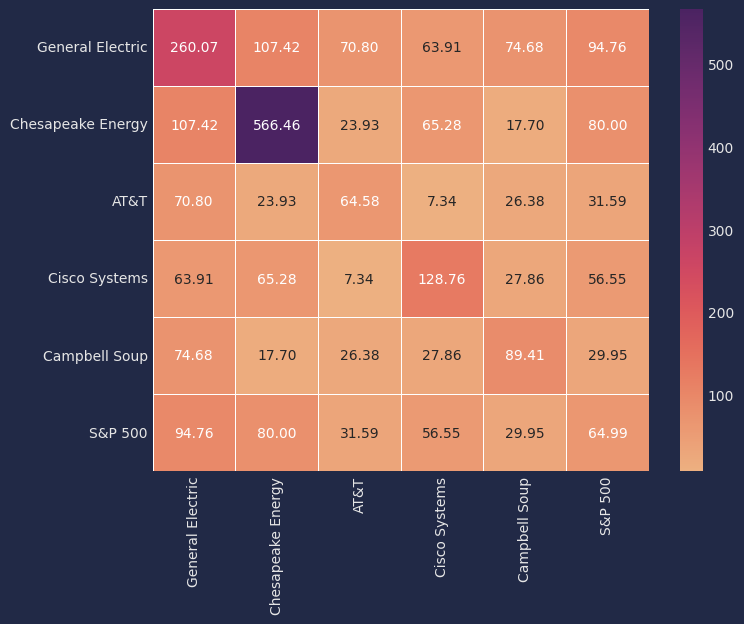

In [15]:
corr_matrix = df.iloc[:, -6:].corr()
corr_matrix.columns = company_list
corr_matrix.index = company_list
plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(corr_matrix, annot=True, cmap="flare", fmt=".2f", linewidths=0.5)
cov_matrix = df.iloc[:, -6:].cov()
cov_matrix.columns = company_list
cov_matrix.index = company_list
plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(cov_matrix, annot=True, cmap="flare", fmt=".2f", linewidths=0.5)

In [16]:
expected_index_return = 1.7 # Hypothetical Expected Return of the Index
risk_free_rate = 0.68 # 10 Year US Treasury Bond Rate
beta = cov_matrix.iloc[-1, :] / cov_matrix.iloc[-1, -1]
capm = risk_free_rate + beta * (expected_index_return - risk_free_rate)
capm = capm.to_frame().T
beta = beta.to_frame().T
print(capm.round(2))

         General Electric  Chesapeake Energy  AT&T  Cisco Systems  \
S&P 500              2.17               1.94  1.18           1.57   

         Campbell Soup  S&P 500  
S&P 500           1.15      1.7  


In [17]:
req_info = pd.concat([stocks_mean, stocks_std, beta, capm], axis=0)
req_info = req_info.reset_index(drop=True)
req_info["Risk Free Rate"] = [risk_free_rate, 0, 0, risk_free_rate]
metric_names = ["Mean", "Standard Deviation", "Beta", "CAPM"]
req_info.insert(0, "Metric", metric_names)
print(req_info)

               Metric  General Electric  Chesapeake Energy      AT&T  \
0                Mean         -1.200000          -3.060000 -0.150000   
1  Standard Deviation         16.130000          23.800000  8.040000   
2                Beta          1.458044           1.231035  0.486117   
3                CAPM          2.167205           1.935656  1.175839   

   Cisco Systems  Campbell Soup  S&P 500  Risk Free Rate  
0       1.850000       0.850000     1.77            0.68  
1      11.350000       9.460000     8.06            0.00  
2       0.870203       0.460877     1.00            0.00  
3       1.567607       1.150095     1.70            0.68  


In [18]:
def return_portfolios(expected_returns, cov_matrix, risk_free_rate):
    """
    Generates a set of random portfolios and computes their Returns,
    Volatility, Sharpe Ratio, and individual asset weights.

    Parameters:
      expected_returns : pd.Series or pd.DataFrame (one row)
          Expected returns for each asset. If provided as a DataFrame,
          it should have a single row.
      cov_matrix : pd.DataFrame
          Covariance matrix for the assets.
      risk_free_rate : float
          The risk-free rate used in the Sharpe ratio calculation.

    Returns:
      pd.DataFrame
          A DataFrame of simulated portfolios with columns for Returns, 
          Volatility, Sharpe Ratio, and each asset's weight.
    """

    # Ensure expected_returns is a 1D array.
    if isinstance(expected_returns, pd.DataFrame):
        if expected_returns.shape[0] == 1:
            # Convert the single row into a Series.
            expected_returns = expected_returns.iloc[0]
        else:
            raise ValueError("expected_returns DataFrame must have only one row.")
    
    # If expected_returns is a Series, extract asset names.
    if isinstance(expected_returns, pd.Series):
        asset_names = list(expected_returns.index)
        expected_returns = expected_returns.values  # now a 1D NumPy array
    else:
        # If it is already a NumPy array, create generic names.
        asset_names = [f"Asset_{i}" for i in range(len(expected_returns))]

    # Convert cov_matrix to a NumPy array if it's a DataFrame.
    if isinstance(cov_matrix, pd.DataFrame):
        cov_matrix = cov_matrix.values
    
    port_returns = []
    port_volatility = []
    port_sharpes = []
    stock_weights = []
    
    num_assets = len(asset_names)
    num_portfolios = 5000
    
    for _ in range(num_portfolios):
        # Generate random weights and normalize them.
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        # Calculate portfolio return.
        ret = np.dot(weights, expected_returns)
        
        # Calculate portfolio volatility.
        vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        # Calculate Sharpe ratio.
        sharpe = (ret - risk_free_rate) / vol
        
        port_returns.append(ret)
        port_volatility.append(vol)
        port_sharpes.append(sharpe)
        stock_weights.append(weights)
        
    # Create a dictionary to hold portfolio metrics.
    portfolio = {
        'Returns': port_returns,
        'Volatility': port_volatility,
        'Sharpe Ratio': port_sharpes
    }
    
    # Add each asset's weight to the dictionary.
    for counter, symbol in enumerate(asset_names):
        portfolio[symbol + ' Weight'] = [w[counter] for w in stock_weights]
        
    # Create and re-order the DataFrame.
    df = pd.DataFrame(portfolio)
    column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [name + ' Weight' for name in asset_names]
    df = df[column_order]
    
    return df
random_portfolios = return_portfolios(capm, cov_matrix, risk_free_rate)
random_portfolios

,Returns,Volatility,Sharpe Ratio,General Electric Weight,Chesapeake Energy Weight,AT&T Weight,Cisco Systems Weight,Campbell Soup Weight,S&P 500 Weight
0,1.745746,10.677400,0.099813,0.205270,0.276908,0.055238,0.240799,0.099252,0.122534
1,1.667259,10.292467,0.095921,0.131192,0.291107,0.031591,0.059557,0.251302,0.235252
2,1.644788,8.492716,0.113602,0.213410,0.086473,0.180797,0.203715,0.097396,0.218208
3,1.636096,9.690818,0.098660,0.092777,0.267457,0.084572,0.125203,0.198894,0.231096
4,1.650778,9.058570,0.107167,0.210740,0.168334,0.146156,0.146202,0.166183,0.162385
...,...,...,...,...,...,...,...,...,...
4995,1.482240,8.230914,0.097467,0.206112,0.093669,0.256668,0.082278,0.346790,0.014483
4996,1.613426,8.381827,0.111363,0.170718,0.071467,0.027249,0.250717,0.246769,0.233080
4997,1.679987,9.891774,0.101093,0.125362,0.259795,0.132171,0.225628,0.073929,0.183115
4998,1.623248,9.212745,0.102385,0.329569,0.101219,0.280490,0.118329,0.167107,0.003287


6. Plot the random portfolios.

<Axes: xlabel='Volatility', ylabel='Returns'>

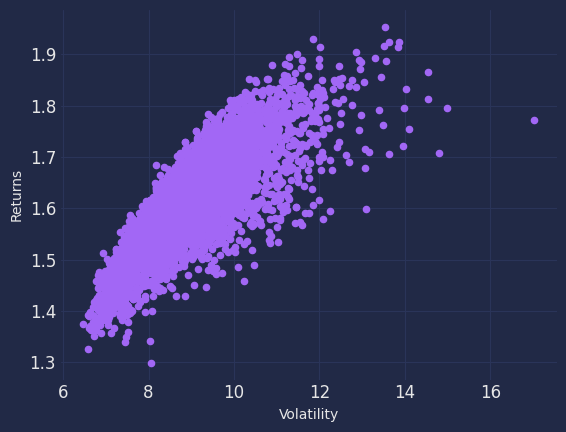

In [19]:
# 6. Plot the set of random porfolios
random_portfolios.plot.scatter(x = 'Volatility', y = 'Returns', fontsize=12)


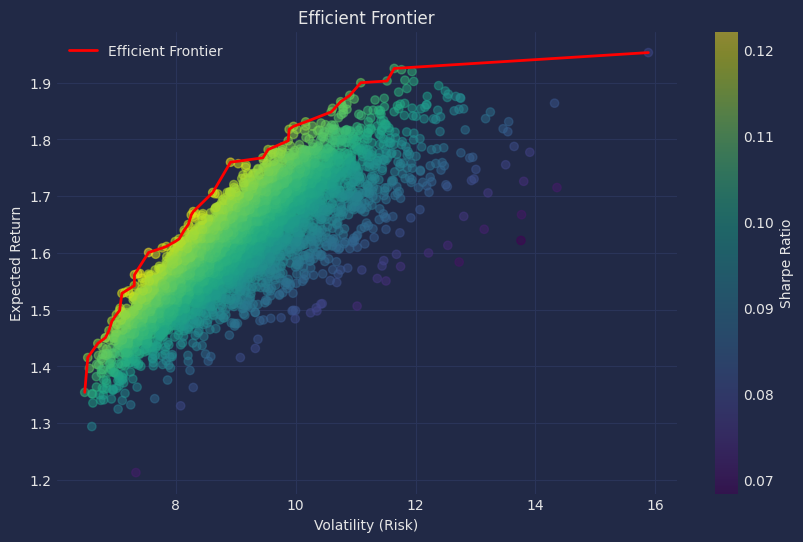

In [20]:

# Generate random portfolios
random_portfolios = return_portfolios(capm, cov_matrix, risk_free_rate)

# Extract Returns and Volatility
returns = random_portfolios["Returns"]
volatility = random_portfolios["Volatility"]

# Find the efficient frontier: Sort portfolios by return and take the min volatility at each level
efficient_frontier = pd.DataFrame()
for ret in np.linspace(returns.min(), returns.max(), 100):
    subset = random_portfolios[random_portfolios["Returns"] >= ret]
    if not subset.empty:
        min_vol = subset.loc[subset["Volatility"].idxmin()]
        efficient_frontier = pd.concat([efficient_frontier, min_vol.to_frame().T])

# Plot the portfolios
plt.figure(figsize=(10, 6))
plt.scatter(volatility, returns, c=random_portfolios["Sharpe Ratio"], cmap="viridis", alpha=0.5)
plt.colorbar(label="Sharpe Ratio")

# Plot the efficient frontier
plt.plot(efficient_frontier["Volatility"], efficient_frontier["Returns"], color="red", linewidth=2, label="Efficient Frontier")

# Labels and title
plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier")
plt.legend()
plt.grid(True)
plt.show()
